In [1]:
import pandas as pd
import  tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

In [2]:
train_df=pd.read_csv("Data/train.csv", encoding='unicode_escape')

In [3]:
test_df=pd.read_csv("Data/test.csv", encoding='unicode_escape')

In [4]:
test_df.columns

Index(['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User',
       'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'],
      dtype='object')

In [5]:
train_df.drop(columns=['textID','selected_text', 'Time of Tweet',
                        'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
                        'Density (P/Km²)'],inplace=True)

In [6]:
train_df['rating'] = train_df.sentiment.apply(lambda x: 1 if x == "positive" else 0 )

In [7]:
train_df=train_df[train_df.sentiment != "neutral"]

In [8]:
test_df.drop(columns=['textID', 'Time of Tweet',
                      'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
                      'Density (P/Km²)'], inplace=True)
test_df['rating'] = test_df.sentiment.apply(lambda x: 1 if x == "positive"  else 0)

In [9]:
test_df=test_df[test_df.sentiment != "neutral"]

In [10]:
train_df["text"]=train_df["text"].astype('string')
train_df["sentiment"]=train_df["sentiment"].astype('string')
test_df["text"]=test_df["text"].astype('string')
test_df["sentiment"]=test_df["sentiment"].astype('string')

In [11]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [12]:
train_df

,text,sentiment,rating
1,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,my boss is bullying me...,negative,0
3,what interview! leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",negative,0
6,2am feedings for the baby are fun when he is a...,positive,1
...,...,...,...
27475,enjoy ur night,positive,1
27476,wish we could come see u on Denver husband l...,negative,0
27477,I`ve wondered about rake to. The client has ...,negative,0
27478,Yay good for both of you. Enjoy the break - y...,positive,1


In [13]:
ros=RandomOverSampler(random_state=42)

In [14]:
x_train, y_train = ros.fit_resample(train_df.drop(columns=["sentiment","rating"]), train_df.rating)
x_test=test_df.drop(columns=["sentiment","rating"])
y_test=test_df.rating

In [15]:
stop_words = stopwords.words('english')
x_train['text'] = x_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
x_test['text'] = x_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [16]:
x_train

,text
0,Sooo SAD I miss San Diego!!!
1,boss bullying me...
2,interview! leave alone
3,"Sons ****, couldn`t put releases already bought"
4,2am feedings baby fun smiles coos
...,...
17159,I miss much I wish I enough money
17160,real stressed
17161,dissapointment hhaha
17162,that`s weird seeing MySpace page without there...


In [17]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train.text)
word_index = tokenizer.word_index

In [19]:
sequences = tokenizer.texts_to_sequences(x_train.text)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, truncating="post")
testing_sentences = tokenizer.texts_to_sequences(x_test.text)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sentences, maxlen=max_length,truncating="post")

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 640,289
Trainable params: 640,289
Non-trainable params: 0
__________________________________________________

In [22]:
model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [23]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)

In [24]:
num_epochs = 25
history = model.fit(padded, training_labels_final, epochs=num_epochs)

Epoch 1/25
537/537 [==============================] - 8s 11ms/step - loss: 0.6877 - accuracy: 0.5579
Epoch 2/25
537/537 [==============================] - 6s 12ms/step - loss: 0.5699 - accuracy: 0.7527
Epoch 3/25
537/537 [==============================] - 7s 13ms/step - loss: 0.4064 - accuracy: 0.8410
Epoch 4/25
537/537 [==============================] - 6s 12ms/step - loss: 0.3222 - accuracy: 0.8771
Epoch 5/25
537/537 [==============================] - 7s 12ms/step - loss: 0.2770 - accuracy: 0.8992
Epoch 6/25
537/537 [==============================] - 6s 12ms/step - loss: 0.2448 - accuracy: 0.9153
Epoch 7/25
537/537 [==============================] - 6s 12ms/step - loss: 0.2218 - accuracy: 0.9233
Epoch 8/25
537/537 [==============================] - 7s 12ms/step - loss: 0.1995 - accuracy: 0.9322
Epoch 9/25
537/537 [==============================] - 7s 12ms/step - loss: 0.1852 - accuracy: 0.9367
Epoch 10/25
537/537 [==============================] - 6s 12ms/step - loss: 0.1749 - accura

In [25]:
predict = model.predict(testing_padded,verbose=1)

66/66 [==============================] - 1s 4ms/step


In [26]:
predict_val=[]
for x in range(len(predict)):
    if predict[x] >= 0.5:
        predict_val.append(1)
    else :   predict_val.append(0)  

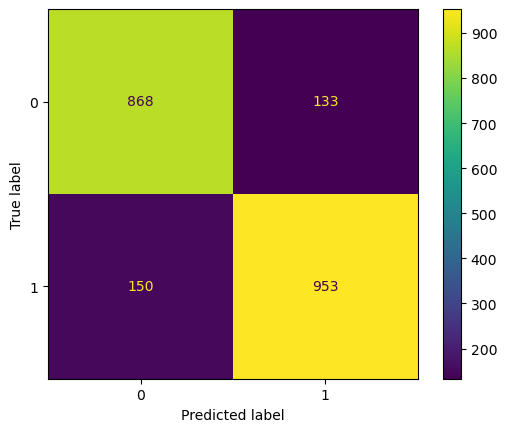

In [27]:
conf_mat = confusion_matrix(y_test, predict_val)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [28]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


In [53]:
def sentiment_check(text):
    
    model = tf.keras.models.load_model('my_model')
    stop_words = set(stopwords.words('english'))
 
    word_tokens = word_tokenize(text)
    # converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    #with no lower case conversion
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    # Join the filtered words to form a clean text        
    clean_text =[ ' '.join(filtered_sentence)]
    testing_sentences = tokenizer.texts_to_sequences(clean_text)
    testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sentences, maxlen=max_length,truncating="post")
    predict = model.predict(testing_padded,verbose=1)
    predict_val=[]
    for x in range(len(predict)):
        if predict[x] >= 0.5:
            predict_val.append(1)
        else :   predict_val.append(0)

    if predict_val[0] == 1 :
        result="This sentence is Positive"
    else : result="This sentence is Negetive"

    return print(result)

In [59]:
sentiment_check("""A terrible movie as everyone has said. What made me laugh was the cameo appearance 
by Scott McNealy, giving an award to one of the murdered programmers in front of a wall of SUN logos. 
McNealy is the CEO of SUN Microsystem, a company that practically defines itself by its hatred of Microsoft. 
They have been instrumental in filing antitrust complaints against Microsoft. 
So, were they silly enough to think this bad movie would add fuel to that fire?<br /><br />There's no public record I see of SUN's involvement, 
but clearly the makers of this movie know Scott McNealy. An interesting mystery.""")

1/1 [==============================] - 0s 161ms/step
This sentence is Negetive


In [61]:
sentiment_check("""Finally watched this shocking movie last night, and what a disturbing mindf**ker it is, 
and unbelievably bloody and some unforgettable scenes, and a total assault on the senses. 
Looks like a movie from the minds of Lynch (specifically ERASERHEAD), Buttgereit, and even a little of "Begotten". 
What this guy does to his pregnant sister is beyond belief, but then again, did it 
really happen or is it his brain's left and right sides doing battle. 
That's the main theme of this piece of art, to draw a fine line between fantasy and reality, 
and what would happen if the right side of the brain that dreams and fantasizes overtakes the reasoning and logical left side. 
And the music in this movie is unbelievable, a kind of electronic score that is absolutely perfect. 
Even though this movie is totally shocking and pretty disgusting in some of the most extreme scenes (including hard core sex) 
you will ever see in any movie, 
I viewed it as a work of art, and loved it. And that music still amazes me, I have to try and find the soundtrack if is available. 
Watching "Subconscious Cruelty" is a real event, and not something the viewer will easily forget. And a note to gorehounds, 
this is a must-have.<br /><br />Warning... Be careful buying this movie, 
because some prints have fogging on the graphic sex scenes and extreme gore, 
especially the copies from the Japanese release.""")

1/1 [==============================] - 0s 136ms/step
This sentence is Positive


In [62]:
sentiment_check("""I saw this film via one of the actors' agents, and it surely conforms with a great deal that comes out of Sth. 
Australia in terms of the overall *tone,* which is rightly dark and moody.<br /><br />I thought the little boy in the film was excellent. 
Mostly kid actors are *hammed up* and embarrassing but not in this case. He was really very good. In terms of the 
*surrealism* thingy mentioned by jingo, well, I just think this film is plain 'weird.' It's a real weirdo film, with weirdo locations, 
storyline, weird stuff going on the whole time. But 'good' weird as opposed to 'bad'.<br /><br />Its hard to think of other movies like it, 
but its not at all like CARS ATE Paris, maybe more like a REPULSION, but actually I think more like a Hammer movie from the 60's. 
Its certainly has an interesting mind working behind it.<br /><br />JINGO, My question is also about the title. Why Modern Love?? Anyone? Also, 
jingo, what did you mean by "god Forsaken" when you were talking about Australia, hmmm? Just curious""")

1/1 [==============================] - 0s 154ms/step
This sentence is Positive


In [65]:
sentiment_check("""A feminist tract in which if you the viewer believe that: i) wild animals are seldom tamed by singing but instead attack, 
kill and eat (the line that grizzlies never attack unless provoked was a hoot - unless "provoked" means that it sees flesh); ii) 
homosexuality is both immoral per se -- and its acceptance almost always associated throughout history with signs of a society's 
dissolution and decay iii) few women are bisexual (in this one, virtually every woman is presented as having no preference for men or women) 
iv) divorce is far worse than infidelity v) land is there for human beings to use, develop and enjoy vi) 
it is as incumbent upon a mother of an adult son to keep in touch as it is upon the son vii) a mother raising her son alone is an 
unfortunate and real tragedy for the child viii) the idolization of a parent for worthwhile ideals is a good and healthy thing ix) 
adults continue to bear a responsibility for their sexual behavior, no matter their age, and the duty to engage in this most 
intimate and giving of acts only within the most intimate and openly sacrificial of relationships: marriage -- believe me,
you are NOT going to like this film! Essentially it's a Howard Stern sort of fellow who is brought down by a Jane Fonda sort of woman 
(think The Electric Horseman). It's ugly stuff because the values, the ideals, of the screenplay are all so harmful.<br /><br />
I share the other objections about the odd things in the writing: a) why would this man lose every girlfriend he has -- because he refuses to reveal
that his mother's death and funeral caused him to be unable to keep dates with them? It's a mystery why he just keeps saying
"it was personal" when faced with angry and disappointed women. HUH? <br /><br />b) there's an enormous inconsistency (i.e., 
the screenwriter wants to have it both ways) by telling us that the protagonist's mother loved the father with everything she had - 
and then later we're told that there was only one great love in her life - her lesbian girlfriend.<br /><br />c) the underlying legal assumptions 
are nonsense. We're never told that the executor has any right to live at the property - merely that she shall determine the 
timing of the sole heir's title and right to occupy the property. Yet somehow the film makes it appear that the executor is the rightful occupant - 
which is crazy. (Try to think of any executor of any will who uses the decedent's property before the will's bequests are fulfilled - it doesn't happen).
<br /><br />d) the assumption throughout this film is that women are equally drawn to men and women - it's just absurd. Thus, we're told: i) that 
Penelope Ann Miller's character is dating other men near the end of the film - after having been with the decedent for five years - and before 
that in a fulfilling relationship with the protagonist, ii) that the protagonist's housekeeper after being devoted throughout her adult life 
to her kind husband - is now dating another woman iii) that one girlfriend upset with the protagonist would now therefore "like to try 
a woman".<br /><br />iv) that a male transsexual is eager to date the protagonist v) that Mary Kay Place's character naturally looked 
at other women in college ("and they looked back" she says with an idiotic triumphal flip of the head).<br /><br />
This is all just ridiculous.<br /><br />I agree with others about the sound of the DVD (I had to keep it at maximum volume and 
repeatedly rewind to understand names, phrases).<br /><br />This is a film by someone who really despises traditional heroics by any man,
hates the notion that a man is needed to raise a child, loathes the idea that there is any necessary connection between marriage and sex. 
The film is out to preach - and that kind of propaganda of false messages doesn't sit well.""")

1/1 [==============================] - 0s 163ms/step
This sentence is Negetive
